PyTorch UNet implementation using IceNet library for data download and post-processing of sea ice forecasting.

This notebook has been designed to be independent of other notebooks.

### Highlights
The key features of this notebook are:
* [1. Download](#1.-Download) 
* [2. Data Processing](#2.-Data-Processing)
* [3. Train](#3.-Train)
* [4. Prediction](#4.-Prediction)
* [5. Outputs and Plotting](#5.-Outputs-and-Plotting)

Please note that this notebook relies on a pytorch data loader implementation which is only available from icenet v0.2.8+.

To install the necessary python packages, you can use the conda `icenet-notebooks/pytorch/environment.yml` environment file on a Linux system to be able to set-up the necessary pytorch + tensorflow + CUDA + other modules which could be a tricky mix to get working manually:

```bash
conda env create -f environment.yml
```

### Contributions
#### PyTorch implementation of IceNet

Andrew McDonald ([icenet-gan](https://github.com/ampersandmcd/icenet-gan))

Bryn Noel Ubald (Refactor, updates for daily predictions and matching icenet library)

#### Notebook
Bryn Noel Ubald (author)

#### PyTorch Integration
Bryn Noel Ubald

Ryan Chan

### How to Download Daily Data for IceNet

#### DOWNLOAD SIC Data  

To download Sea Ice Concentration (SIC) data, modify the script below with the desired date range:

```python
sic = SICDownloader(
    dates=[
        pd.to_datetime(date).date()  # Dates to download SIC data for
        for date in pd.date_range("2020-01-01", "2020-12-31", freq="D")
    ],
    delete_tempfiles=True,           # Delete temporary downloaded files after use
    north=True,                     # Use mask for the Northern Hemisphere (set to True if needed)
    south=False,                      # Use mask for the Southern Hemisphere
    parallel_opens=True,             # Enable parallel processing with dask.delayed
)

sic.download()
```

#### Download ERA5 Data  

##### Setup ERA5 API

Use the following link to set up the ERA5 API: [https://cds.climate.copernicus.eu/how-to-api?](https://cds.climate.copernicus.eu/how-to-api?).

Run the following script with your desired dates:

#### ERA5 Downloader  

```python
import pandas as pd
from icenet.data.interfaces.cds import ERA5Downloader

era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],      # Name of variables to download
    dates=[                                     # Dates to download the variable data for
        pd.to_datetime(date).date()
        for date in pd.date_range("2020-01-01", "2020-12-31", freq="D")
    ],
    path="./data",                              # Location to download data to (default is `./data`)
    delete_tempfiles=True,                      # Whether to delete temporary downloaded files
    levels=[None, [250, 500], None, None],      # The levels at which to obtain the variables for (e.g. for zg, it is the pressure levels)
    max_threads=4,                              # Maximum number of concurrent downloads
    north=True,                                # Boolean: Whether require data across northern hemisphere
    south=False,                                 # Boolean: Whether require data across southern hemisphere
    use_toolbox=False)                          # Experimental, alternative download method

era5.download()                                 # Start downloading
```

The prototype data currently in use (South Pole, 2020) can be downloaded from **Baskerville** at the following path: `/vjgo8416-ice-frcst/shared/prototype_data/`


In [1]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_float32_matmul_precision('medium')

## 1. Download

In [2]:
import numpy
from icenet.data.sic.mask import Masks
from icenet.data.interfaces.cds import ERA5Downloader
from icenet.data.sic.osisaf import SICDownloader

In [3]:
# Unset SLURM_NTASKS if it's causing issues
if "SLURM_NTASKS" in os.environ:
    del os.environ["SLURM_NTASKS"]

# Optionally, set SLURM_NTASKS_PER_NODE if needed
os.environ["SLURM_NTASKS_PER_NODE"] = "1"  # or whatever value is appropriate

### Mask data

Create masks for masking data.

In [4]:
masks = Masks(north=True, south=False)
masks.generate(save_polarhole_masks=False)

INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_01.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_02.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_03.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_04.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_05.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_06.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_07.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_08.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_09.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_10.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_11.npy, already exists
INFO:root:Skipping ./

### Climate and Sea Ice data

Download climate variables from ERA5 and sea ice concentration from OSI-SAF.

In [5]:
era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],
    levels=[None, [250, 500], None, None],
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2018-01-01", "2020-12-31", freq="D")],
    delete_tempfiles=False,
    max_threads=64,
    north=True,
    south=False,
    # NOTE: there appears to be a bug with the toolbox API at present (icenet#54)
    use_toolbox=False
)

# era5.download()

INFO:root:Upping connection limit for max_threads > 10


In [6]:
sic = SICDownloader(
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2018-01-01", "2020-12-31", freq="D")],
    delete_tempfiles=False,
    north=True,
    south=False,
    parallel_opens=False,
)

# sic.download()

Re-grid ERA5 reanalysis data, and rotate wind vector data from ERA5 to align with EASE2 projection.

In [7]:
era5.regrid()
era5.rotate_wind_data()

INFO:root:No regrid batches to processing, moving on...
INFO:root:Rotating wind data prior to merging
INFO:root:Rotating wind data in ./data/era5/north/uas ./data/era5/north/vas
INFO:root:0 files for uas
INFO:root:0 files for vas
INFO:root:Rotating wind data in ./data/era5/north/uas ./data/era5/north/vas
INFO:root:0 files for uas
INFO:root:0 files for vas


## 2. Data Processing

Process downloaded datasets.

To make life easier, setting up train, val, test dates.

In [8]:
# 1to7Apr 2018-2020
processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2018-01-01", "2019-03-29")],
    val=[pd.to_datetime(el) for el in pd.date_range("2019-03-30", "2019-06-30")],
    test=[pd.to_datetime(el) for el in pd.date_range("2020-04-01", "2020-04-07")],
)
processed_name = "notebook_api_pytorch_data"

Next, we create the data producer and configure them for the dataset we want to create.

In [9]:
from icenet.data.processors.era5 import IceNetERA5PreProcessor
from icenet.data.processors.meta import IceNetMetaPreProcessor
from icenet.data.processors.osi import IceNetOSIPreProcessor

pp = IceNetERA5PreProcessor(
    ["uas", "vas"],
    ["tas", "zg500", "zg250"],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=True,
    south=False
)

osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=True,
    south=False
)

meta = IceNetMetaPreProcessor(
    processed_name,
    north=True,
    south=False
)

2025-10-22 17:21:07.956407: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 17:21:08.000835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-22 17:21:08.000878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-22 17:21:08.002395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-22 17:21:08.012308: I tensorflow/core/platform/cpu_feature_guar

Next, we initialise the data processors using `init_source_data` which scans the data source directories to understand what data is available for processing based on the parameters. Since we named the processed data `"notebook_api_data"` above, it will create a data loader config file, `loader.notebook_api_data.json`, in the current directory.

In [10]:
# Causes hanging on training, when generating sample.
pp.init_source_data(
    lag_days=1,
)
pp.process()

osi.init_source_data(
    lag_days=1,
)
osi.process()

meta.process()

INFO:root:Processing 453 dates for train category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Processing 93 dates for val category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Processing 7 dates for test category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Got 4 files for tas
INFO:root:Got 4 files for uas
INFO:root:Got 4 files for vas
INFO:root:Got 4 files for zg250
INFO:root:Got 4 files for zg500
INFO:root:Opening files for uas
INFO:root:Filtered to 1461 units long based on configuration requirements
INFO:root:Normalising uas
INFO:root:Opening files for vas
INFO:root:Filtered to 1461 units long based on configuration requirements
INFO:root:Normalising vas
INFO:root:Opening files for tas
INFO:root:Filtered to 1461 units long based on configuration requirements
INFO:root:Reusing climatology ./processed/notebook_api_pytorch_data/era5/north/params/climatology.tas
INFO:root:Normalisin

At this point the preprocessed data is ready to convert or create a configuration for the network dataset.

### Dataset creation

As with the `icenet_dataset_create` command we can create a dataset configuration for training the network. As before this can include cached data for the network in the format of a TFRecordDataset compatible set of tfrecords. To achieve this we create the `IceNetDataLoader`, which can both generate `IceNetDataSet` configurations (which easily provide the necessary functionality for training and prediction) as well as individual data samples for direct usage.

In [11]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_pytorch_data.json"
dataset_name = "notebook_api_pytorch_data"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=True,
    south=False,
    output_batch_size=1,
    generate_workers=4)

INFO:root:Loading configuration loader.notebook_api_pytorch_data.json


At this point we can either use `generate` or `write_dataset_config_only` to produce a ready-to-go `IceNetDataSet` configuration. Both of these will generate a dataset config, `dataset_config.notebook_api_pytorch_data.json` (recall we set the dataset name as `notebook_api_pytorch_data` above).

In this case, for pytorch, will read data in directly, rather than using cached tfrecords inputs.

In [12]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:453 train dates in total, NOT generating cache data.
INFO:root:93 val dates in total, NOT generating cache data.
INFO:root:7 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.notebook_api_pytorch_data.json


We can now create the IceNetDataSet object:

In [13]:
from icenet.data.dataset import IceNetDataSetPyTorch
dataset_config = f"dataset_config.{dataset_name}.json"

In [14]:
batch_size = 4
shuffle = False
persistent_workers=True
num_workers = 4

## 3. Train

We implement a custom PyTorch class for training.

## IceNet2 UNet model

PyTorch UNet implementation based on current state of IceNet2, and Andrew's work from https://github.com/ampersandmcd/icenet-gan/.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode):
        super().__init__()
        self.interp = F.interpolate
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

class UNet(nn.Module):
    def __init__(self,
                 input_channels,
                 filter_size=3,
                 n_filters_factor=1,
                 n_forecast_days=7,
                 n_output_classes=1,
                 **kwargs
                 ):
        super(UNet, self).__init__()

        self.input_channels = input_channels
        self.filter_size = filter_size
        self.n_filters_factor = n_filters_factor
        self.n_forecast_days = n_forecast_days
        self.n_output_classes = n_output_classes

        start_out_channels = 64
        reduced_channels = int(start_out_channels * n_filters_factor)
        channels = {
            start_out_channels * 2**pow: reduced_channels * 2**pow
            for pow in range(4)
        }

        # Encoder
        self.conv1 = self.conv_block(input_channels, channels[64])
        self.conv2 = self.conv_block(channels[64], channels[128])
        self.conv3 = self.conv_block(channels[128], channels[256])
        self.conv4 = self.conv_block(channels[256], channels[256])

        # Bottleneck
        self.conv5 = self.bottleneck_block(channels[256], channels[512])

        # Decoder
        self.up6 = self.upconv_block(channels[512], channels[256])
        self.up7 = self.upconv_block(channels[256], channels[256])
        self.up8 = self.upconv_block(channels[256], channels[128])
        self.up9 = self.upconv_block(channels[128], channels[64])

        self.up6b = self.conv_block(channels[512], channels[256])
        self.up7b = self.conv_block(channels[512], channels[256])
        self.up8b = self.conv_block(channels[256], channels[128])
        self.up9b = self.conv_block(channels[128], channels[64], final=True)

        # Final layer
        self.final_layer = nn.Conv2d(channels[64], n_forecast_days, kernel_size=1, padding="same")

    def forward(self, x):
        # transpose from shape (b, h, w, c) to (b, c, h, w) for pytorch conv2d layers
        x = torch.movedim(x, -1, 1)  # move c from last to second dim

        # Encoder
        bn1 = self.conv1(x)
        conv1 = F.max_pool2d(bn1, kernel_size=2)
        bn2 = self.conv2(conv1)
        conv2 = F.max_pool2d(bn2, kernel_size=2)
        bn3 = self.conv3(conv2)
        conv3 = F.max_pool2d(bn3, kernel_size=2)
        bn4 = self.conv4(conv3)
        conv4 = F.max_pool2d(bn4, kernel_size=2)

        # Bottleneck
        bn5 = self.conv5(conv4)

        # Decoder
        up6 = self.up6b(torch.cat([bn4, self.up6(bn5)], dim=1))
        up7 = self.up7b(torch.cat([bn3, self.up7(up6)], dim=1))
        up8 = self.up8b(torch.cat([bn2, self.up8(up7)], dim=1))
        up9 = self.up9b(torch.cat([bn1, self.up9(up8)], dim=1))

        # Final layer
        output = self.final_layer(up9)

        # transpose from shape (b, c, h, w) back to (b, h, w, c) to align with training data
        output = torch.movedim(output, 1, -1)  # move c from second to final dim

        b, h, w, c = output.shape

        # unpack c=classes*months dimension into classes, months as separate dimensions
        output = output.reshape((b, h, w, self.n_output_classes, self.n_forecast_days))

        return output

    def conv_block(self, in_channels, out_channels, final=False):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
        )
        if not final:
            batch_norm = nn.Sequential(
                nn.BatchNorm2d(num_features=out_channels),
            )
            return nn.Sequential().extend(block).extend(batch_norm)
        else:
            final_block = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
                nn.ReLU(inplace=True),
            )
            return nn.Sequential().extend(block).extend(final_block)


    def bottleneck_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=out_channels),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            Interpolate(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=2, padding="same"),
            nn.ReLU(inplace=True)
        )

Define custom metrics for use in validation and monitoring

In [16]:
from torchmetrics import Metric

class IceNetAccuracy(Metric):
    """Binary accuracy metric for use at multiple leadtimes.

    Reference: https://lightning.ai/docs/torchmetrics/stable/pages/implement.html
    """    

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = True
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Custom loss/metric for binary accuracy in classifying SIC>15% for multiple leadtimes.

        Args:
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider first six days in accuracy computation or
                e.g., [0] to only look at the first day's accuracy
                e.g., [5] to only look at the sixth day's accuracy
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("weighted_score", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("possible_score", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        preds = (preds > 0.15).long() # torch.Size([2, 432, 432, 7])
        target = (target > 0.15).long() # torch.Size([2, 432, 432, 7])
        base_score = preds[:, :, :, self.leadtimes_to_evaluate] == target[:, :, :, self.leadtimes_to_evaluate]
        self.weighted_score += torch.sum(base_score * sample_weight[:, :, :, self.leadtimes_to_evaluate])
        self.possible_score += torch.sum(sample_weight[:, :, :, self.leadtimes_to_evaluate])

    def compute(self):
        return self.weighted_score.float() / self.possible_score * 100.0


class SIEError(Metric):
    """
    Sea Ice Extent error metric (in km^2) for use at multiple leadtimes.
    """ 

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = False
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Construct an SIE error metric (in km^2) for use at multiple leadtimes.
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider six days in computation or
                e.g., [0] to only look at the first day
                e.g., [5] to only look at the sixth day
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("pred_sie", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("true_sie", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        preds = (preds > 0.15).long()
        target = (target > 0.15).long()
        self.pred_sie += preds[:, :, :, self.leadtimes_to_evaluate].sum()
        self.true_sie += target[:, :, :, self.leadtimes_to_evaluate].sum()

    def compute(self):
        return (self.pred_sie - self.true_sie) * 25**2 # each pixel is 25x25 km

Define custom loss functions

In [17]:
class WeightedBCEWithLogitsLoss(nn.BCEWithLogitsLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted BCEWithLogitsLoss loss.

        Compute BCEWithLogitsLoss loss weighted by masking.

        Using BCEWithLogitsLoss instead of BCELoss, as pytorch docs mentions it is
        more numerically stable.
        https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
        
        """
        # Computing using nn.BCEWithLogitsLoss base class. This class must be instantiated via:
        # >>> criterion = WeightedBCEWithLogitsLoss(reduction='none')
        loss = super().forward(
                            (inputs.movedim(-2, 1)),
                            (targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)
        
        return loss.mean()

class WeightedL1Loss(nn.L1Loss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted L1 loss.

        Compute L1 loss weighted by masking.
        
        """
        y_hat = torch.sigmoid(inputs)

        # Computing using nn.L1Loss class. This class must be instantiated via:
        # >>> criterion = WeightedL1Loss(reduction="none")
        loss = super().forward(
                            (100*y_hat.movedim(-2, 1)), 
                            (100*targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)


        # Computing here, in the derived class
        # loss = (
        #             torch.abs( ( y_hat.movedim(-2, 1) - targets.movedim(-1, 1) )*100 )
        #         )*sample_weights.movedim(-1, 1)
        
        return loss.mean()

class WeightedMSELoss(nn.MSELoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted MSE loss.

        Compute MSE loss weighted by masking.
        
        """
        y_hat = torch.sigmoid(inputs)

        # Computing using nn.MSELoss base class. This class must be instantiated via:
        # criterion = nn.MSELoss(reduction="none")
        loss = super().forward(
                            (100*y_hat.movedim(-2, 1)), 
                            (100*targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)


        # Computing here, in the nn.Module derived class
        # loss = (
        #             ( ( y_hat.movedim(-2, 1) - targets.movedim(-1, 1) )*100 )**2
        #         )*sample_weights.movedim(-1, 1)
        return loss.mean()

A _LightningModule_ wrapper for UNet model.

In [18]:
import lightning.pytorch as pl
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS
from torchmetrics import MetricCollection

class LitUNet(pl.LightningModule):
    """
    A LightningModule wrapping the UNet implementation of IceNet.
    """
    def __init__(self,
                 model: nn.Module,
                 criterion: callable,
                 learning_rate: float):
        """
        Construct a UNet LightningModule.
        Note that we keep hyperparameters separate from dataloaders to prevent data leakage at test time.
        :param model: PyTorch model
        :param criterion: PyTorch loss function for training instantiated with reduction="none"
        :param learning_rate: Float learning rate for our optimiser
        """
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.n_output_classes = model.n_output_classes  # this should be a property of the network

        metrics = {
            "val_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.model.n_forecast_days))),
            "val_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.model.n_forecast_days)))
        }
        for i in range(self.model.n_forecast_days):
            metrics[f"val_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            metrics[f"val_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.metrics = MetricCollection(metrics)

        test_metrics = {
            "test_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.model.n_forecast_days))),
            "test_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.model.n_forecast_days)))
        }
        for i in range(self.model.n_forecast_days):
            test_metrics[f"test_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            test_metrics[f"test_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.test_metrics = MetricCollection(test_metrics)

        # Save input parameters to __init__ (hyperparams) when checkpointing.
        # self.save_hyperparameters(ignore=["model", "criterion"])
        self.save_hyperparameters()

    def forward(self, x):
        """
        Implement forward function.
        :param x: Inputs to model.
        :return: Outputs of model.
        """
        return self.model(x)

    def training_step(self, batch):
        """
        Perform a pass through a batch of training data.
        Apply pixel-weighted loss by manually reducing.
        See e.g. https://discuss.pytorch.org/t/unet-pixel-wise-weighted-loss-function/46689/5.
        :param batch: Batch of input, output, weight triplets
        :param batch_idx: Index of batch
        :return: Loss from this batch of data for use in backprop
        """
        x, y, sample_weight = batch
        outputs = self.model(x)
        # y_hat = torch.sigmoid(outputs)

        # loss = loss_func(outputs, y, sample_weight)
        loss = self.criterion(outputs, y, sample_weight)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return {"loss": loss}

    def validation_step(self, batch):
        # x: (b, h, w, channels), y: (b, h, w, n_forecast_days, classes), sample_weight: (b, h, w, n_forecast_days, classes)
        x, y, sample_weight = batch
        # y_hat: (b, h, w, classes, n_forecast_days)
        outputs = self.model(x)
        y_hat = torch.sigmoid(outputs)

        # loss = loss_func(outputs, y, sample_weight)
        loss = self.criterion(outputs, y, sample_weight)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level loss

        self.metrics.update(y_hat.squeeze(dim=-2), y.squeeze(dim=-1), sample_weight.squeeze(dim=-1))

        return {"val_loss", loss}

    def on_validation_epoch_end(self):
        self.log_dict(self.metrics.compute(), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level metrics
        self.metrics.reset()

    def test_step(self, batch):
        x, y, sample_weight = batch
        outputs = self.model(x)
        y_hat = torch.sigmoid(outputs)

        # loss = loss_func(outputs, y, sample_weight)
        loss = self.criterion(outputs, y, sample_weight)

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level loss

        self.test_metrics.update(y_hat.squeeze(dim=-2), y.squeeze(dim=-1), sample_weight.squeeze(dim=-1))
    
        return loss

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute(), on_step=False, on_epoch=True, sync_dist=True)  # epoch-level metrics
        self.test_metrics.reset()


    def predict_step(self, batch):
        """
        :param batch: Batch of input, output, weight triplets
        :param batch_idx: Index of batch
        :return: Predictions for given input.
        """
        x, y, sample_weight = batch
        y_hat = torch.sigmoid(self.model(x))

        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer
        }

    # def train_dataloader(self) -> TRAIN_DATALOADERS:
    #     return super().train_dataloader()

Function for training UNet model using PyTorch Lightning.

In [19]:
from lightning.pytorch.callbacks import ModelCheckpoint

def train_icenet(configuration_path,
                 learning_rate,
                 max_epochs,
                 batch_size,
                 n_workers,
                 filter_size,
                 n_filters_factor,
                 seed):
    """
    Train IceNet using the arguments specified in the `args` namespace.
    :param args: Namespace of configuration parameters
    """
    # init
    pl.seed_everything(seed)
    
    # configure datasets and dataloaders
    train_dataset = IceNetDataSetPyTorch(configuration_path, mode="train")
    val_dataset = IceNetDataSetPyTorch(configuration_path, mode="val")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers,
                                  persistent_workers=persistent_workers, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers,
                                persistent_workers=persistent_workers, shuffle=False)

    # construct unet
    model = UNet(
        input_channels=train_dataset._num_channels,
        filter_size=filter_size,
        n_filters_factor=n_filters_factor,
        n_forecast_days=train_dataset._n_forecast_days
    )

    # criterion = WeightedBCEWithLogitsLoss(reduction="none")
    # criterion = WeightedL1Loss(reduction="none")
    criterion = WeightedMSELoss(reduction="none")
    
    # configure PyTorch Lightning module
    lit_module = LitUNet(
        model=model,
        criterion=criterion,
        learning_rate=learning_rate
    )

    # set up trainer configuration
    trainer = pl.Trainer(
        accelerator="auto",
        devices=-1,
        log_every_n_steps=5,
        max_epochs=max_epochs,
        num_sanity_val_steps=1,
        fast_dev_run=False, # Runs single batch through train and validation
                            #    when running trainer.test()
                            # Note: Cannot use with automatic best checkpointing
    )
    checkpoint_callback = ModelCheckpoint(monitor="val_accuracy", mode="max")
    trainer.callbacks.append(checkpoint_callback)

    # train model
    print(f"Training {len(train_dataset)} examples / {len(train_dataloader)} batches (batch size {batch_size}).")
    print(f"Validating {len(val_dataset)} examples / {len(val_dataloader)} batches (batch size {batch_size}).")
    trainer.fit(lit_module, train_dataloader, val_dataloader)

    return model, trainer, checkpoint_callback

Conduct actual training run.

In [20]:
seed = 45
model, trainer, checkpoint_callback = train_icenet(
            configuration_path=dataset_config,
            learning_rate=1e-4,
            max_epochs=75,
            batch_size=batch_size,
            n_workers=num_workers,
            filter_size=3,
            n_filters_factor=0.4,
            seed=seed
        )

INFO: [rank: 0] Seed set to 45
INFO:lightning.fabric.utilities.seed:[rank: 0] Seed set to 45
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_

Training 453 examples / 114 batches (batch size 4).
Validating 93 examples / 24 batches (batch size 4).


INFO: 
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | UNet             | 1.7 M  | train
1 | criterion    | WeightedMSELoss  | 0      | train
2 | metrics      | MetricCollection | 0      | train
3 | test_metrics | MetricCollection | 0      | train
----------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.699     Total estimated model params size (MB)
108       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | UNet             | 1.7 M  | train
1 | criterion    | WeightedMSELoss  | 0      | train
2 | metrics      | MetricCollection | 0      | train
3 | test_metrics | MetricCollection | 0      | train
---------------------------------------------

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


Epoch 0: 100%|██████████| 114/114 [00:24<00:00,  4.71it/s, v_num=1127781, train_loss_step=17.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 114/114 [00:22<00:00,  5.08it/s, v_num=1127781, train_loss_step=14.30, val_loss=110.0, val_accuracy=91.20, val_accuracy_0=91.90, val_accuracy_1=91.10, val_accuracy_2=88.00, val_accuracy_3=92.70, val_accuracy_4=89.50, val_accuracy_5=92.70, val_accuracy_6=92.60, val_sieerror=4.72e+10, val_sieerror_0=7.03e+9, val_sieerror_1=7.36e+9, val_sieerror_2=5.09e+9, val_sieerror_3=7.28e+9, val_sieerror_4=5.45e+9, val_sieerror_5=7.54e+9, val_sieerror_6=7.42e+9, train_loss_epoch=155.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 114/114 [00:22<00:00,  5.13it/s, v_num=1127781, train_loss_step=13.80, val_loss=118.0, val_accuracy=91.60, val_accuracy_0=91.60, val_accuracy_1=90.60, val_accuracy_2=89.80, val_accuracy_3=92.30, val_accuracy_4=92.00, val_accuracy_5=92.80, val_accuracy_6=92.00, val_sieerror=3.71e+10,

INFO: `Trainer.fit` stopped: `max_epochs=75` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 74: 100%|██████████| 114/114 [00:28<00:00,  4.05it/s, v_num=1127781, train_loss_step=4.680, val_loss=26.20, val_accuracy=92.50, val_accuracy_0=96.40, val_accuracy_1=95.60, val_accuracy_2=94.00, val_accuracy_3=92.60, val_accuracy_4=91.10, val_accuracy_5=89.60, val_accuracy_6=88.50, val_sieerror=4.86e+10, val_sieerror_0=5.67e+9, val_sieerror_1=6.53e+9, val_sieerror_2=6.89e+9, val_sieerror_3=7.08e+9, val_sieerror_4=7.31e+9, val_sieerror_5=7.49e+9, val_sieerror_6=7.64e+9, train_loss_epoch=5.590]


## 4. Prediction

Predicts using the best checkpoint from the training.

In [21]:
checkpoint_callback.best_k_models

{'/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/lightning_logs/version_1127781/checkpoints/epoch=68-step=7866-v1.ckpt': tensor(95.5473, device='cuda:0')}

In [22]:
best_checkpoint = checkpoint_callback.best_model_path
best_checkpoint

'/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/lightning_logs/version_1127781/checkpoints/epoch=68-step=7866-v1.ckpt'

In [23]:
# Load the best result from the checkpoint
best_model = LitUNet.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
best_model.eval()

LitUNet(
  (model): UNet(
    (conv1): Sequential(
      (0): Conv2d(9, 25, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Sequential(
      (0): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_r

In [24]:
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,
                             persistent_workers=persistent_workers, shuffle=False)

# automatically load the best weights (if best_model isn't added)
trainer.test(dataloaders=test_dataloader)

INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:156: `.test(ckpt_path="best")` is called with Trainer configured with multiple `ModelCheckpoint` callbacks. It will use 

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 17.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          90.73617553710938
     test_accuracy_0         97.42528533935547
     test_accuracy_1         94.8802261352539
     test_accuracy_2         91.82046508789062
     test_accuracy_3         89.83820343017578
     test_accuracy_4         88.1167221069336
     test_accuracy_5         86.97048950195312
     test_accuracy_6          86.101806640625
        test_loss           24.319196701049805
      test_sieerror            4394860544.0
     test_sieerror_0            483232512.0
     test_sieerror_1            619213760.0
     test_sieerror_2            643886272.0
     test_sieerror_3            654371264.0
     t

[{'test_loss': 24.319196701049805,
  'test_accuracy': 90.73617553710938,
  'test_accuracy_0': 97.42528533935547,
  'test_accuracy_1': 94.8802261352539,
  'test_accuracy_2': 91.82046508789062,
  'test_accuracy_3': 89.83820343017578,
  'test_accuracy_4': 88.1167221069336,
  'test_accuracy_5': 86.97048950195312,
  'test_accuracy_6': 86.101806640625,
  'test_sieerror': 4394860544.0,
  'test_sieerror_0': 483232512.0,
  'test_sieerror_1': 619213760.0,
  'test_sieerror_2': 643886272.0,
  'test_sieerror_3': 654371264.0,
  'test_sieerror_4': 660983104.0,
  'test_sieerror_5': 665262528.0,
  'test_sieerror_6': 667911232.0}]

In [25]:
logging.info("Generating predictions")

predictions = trainer.predict(best_model, dataloaders=test_dataloader)

INFO:root:Generating predictions
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 29.07it/s]


In [26]:
for worker, prediction in enumerate(predictions):
    print(f"Worker: {worker} | Prediction: {prediction.shape}")

Worker: 0 | Prediction: torch.Size([4, 432, 432, 1, 7])
Worker: 1 | Prediction: torch.Size([3, 432, 432, 1, 7])


## 5. Outputs and Plotting

Create prediction output directory

In [27]:
# dataset = "pytorch_notebook"
network_name = "api_pytorch_dataset_two"
output_name = "example_pytorch_forecast_two"
output_folder = os.path.join(".", "results", "predict", output_name,
                                "{}.{}".format(network_name, seed))
os.makedirs(output_folder, exist_ok=output_folder)

Convert and output predictions to numpy files

In [28]:
idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        date = pd.Timestamp(test_dataset.dates[idx].replace('_', '-'))
        output_path = os.path.join(output_folder, date.strftime("%Y_%m_%d.npy"))
        forecast = prediction[batch, :, :, :, :].movedim(-2, 0)
        forecast_np = forecast.detach().cpu().numpy()
        np.save(output_path, forecast_np)
        idx += 1

Create a csv file with all the test dates we have predicted for, and to use in generating the final netCDF output using `icenet_output`.

In [29]:
!printf "2020-04-01\n2020-04-02" | tee testdates.csv

2020-04-01
2020-04-02

In [30]:
# !icenet_output -m -o results/predict example_pytorch_forecast_two notebook_api_pytorch_data testdates.csv
import sys
!{sys.executable.replace('python', 'icenet_output')}  -m -o results/predict example_pytorch_forecast_two notebook_api_pytorch_data testdates.csv

2025-10-22 17:57:28.020695: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 17:57:28.085977: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-22 17:57:28.086021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-22 17:57:28.087476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-22 17:57:28.095548: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761150117.bask-pg0308u03a.1840533.0 to lightning_logs/version_1127781/events.out.tfevents.1761152239.bask-pg0308u03a.1840533.1
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761152239.bask-pg0308u03a.1840533.1 to lightning_logs/version_1127781/events.out.tfevents.1761152241.bask-pg0308u03a.1840533.2
INFO:tensorboard:No path found after lightning_logs/version_1127781/events.out.tfevents.1761152241.bask-pg0308u03a.1840533.2


Available tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_accuracy', 'val_accuracy_0', 'val_accuracy_1', 'val_accuracy_2', 'val_accuracy_3', 'val_accuracy_4', 'val_accuracy_5', 'val_accuracy_6', 'val_sieerror', 'val_sieerror_0', 'val_sieerror_1', 'val_sieerror_2', 'val_sieerror_3', 'val_sieerror_4', 'val_sieerror_5', 'val_sieerror_6', 'train_loss_epoch', 'test_loss', 'test_accuracy', 'test_accuracy_0', 'test_accuracy_1', 'test_accuracy_2', 'test_accuracy_3', 'test_accuracy_4', 'test_accuracy_5', 'test_accuracy_6', 'test_sieerror', 'test_sieerror_0', 'test_sieerror_1', 'test_sieerror_2', 'test_sieerror_3', 'test_sieerror_4', 'test_sieerror_5', 'test_sieerror_6']


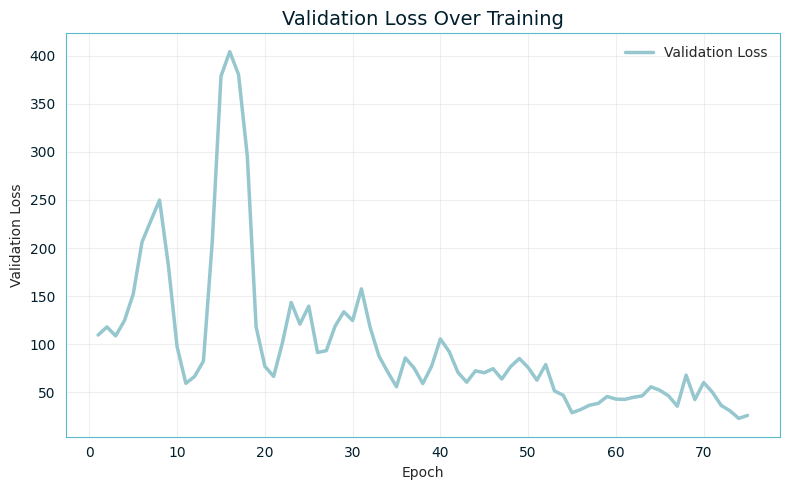

In [31]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for consistency
sns.set_style("whitegrid")

ppt_colors = ["#FFFFFF", "#96C7CF", "#5BBAC9", "#001E2C"]

# Change this to the actual version dir
# log_dir = "lightning_logs/version_1117456" 
log_dir = max([os.path.join("lightning_logs", d) for d in os.listdir("lightning_logs") if d.startswith("version_")], key=os.path.getctime)

# Load the logs
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# List all scalar tags to find the correct name
print("Available tags:", event_acc.Tags()['scalars'])

# Get the scalar events for val_loss
val_loss_events = event_acc.Scalars('val_loss')

steps = list(range(1, len(val_loss_events) + 1))
values = [e.value for e in val_loss_events]

# Plot with custom color theme
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Loss', color=ppt_colors[1], linewidth=2.5)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Training", fontsize=14, color=ppt_colors[3])
plt.legend(frameon=False)
plt.grid(True, alpha=0.3)

# Adjust tick/label colors to match theme
plt.gca().tick_params(colors=ppt_colors[3])
for spine in plt.gca().spines.values():
    spine.set_color(ppt_colors[2])

plt.tight_layout()
# Save the figure before showing
plt.savefig("val_loss_plot_UNET_ISAR_prototype_2018_2020_NORTH_test1to7Apr.png", dpi=300, bbox_inches='tight')
plt.show()


Plotting the forecast

In [33]:
import xarray as xr
import datetime as dt
from IPython.display import HTML

In [34]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks

ds = xr.open_dataset("results/predict/example_pytorch_forecast_two.nc")
land_mask = Masks(south=False, north=True).get_land_mask()
ds.info()

xarray.Dataset {
dimensions:
	time = 2 ;
	yc = 432 ;
	xc = 432 ;
	leadtime = 7 ;

variables:
	int32 Lambert_Azimuthal_Grid() ;
		Lambert_Azimuthal_Grid:grid_mapping_name = lambert_azimuthal_equal_area ;
		Lambert_Azimuthal_Grid:longitude_of_projection_origin = 0.0 ;
		Lambert_Azimuthal_Grid:latitude_of_projection_origin = 90.0 ;
		Lambert_Azimuthal_Grid:false_easting = 0.0 ;
		Lambert_Azimuthal_Grid:false_northing = 0.0 ;
		Lambert_Azimuthal_Grid:semi_major_axis = 6378137.0 ;
		Lambert_Azimuthal_Grid:inverse_flattening = 298.257223563 ;
		Lambert_Azimuthal_Grid:proj4_string = +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=90.0 ;
	float32 sic_mean(time, yc, xc, leadtime) ;
		sic_mean:long_name = mean sea ice area fraction across ensemble runs of icenet model ;
		sic_mean:standard_name = sea_ice_area_fraction ;
		sic_mean:short_name = sic ;
		sic_mean:valid_min = 0 ;
		sic_mean:valid_max = 1 ;
		sic_mean:ancillary_variables = sic_stddev ;
		sic_mean:grid_mapping = Lambert_Azimuthal

Animate result

INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761150117.bask-pg0308u03a.1840533.0 to lightning_logs/version_1127781/events.out.tfevents.1761152239.bask-pg0308u03a.1840533.1
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761152239.bask-pg0308u03a.1840533.1 to lightning_logs/version_1127781/events.out.tfevents.1761152241.bask-pg0308u03a.1840533.2
INFO:tensorboard:No path found after lightning_logs/version_1127781/events.out.tfevents.1761152241.bask-pg0308u03a.1840533.2


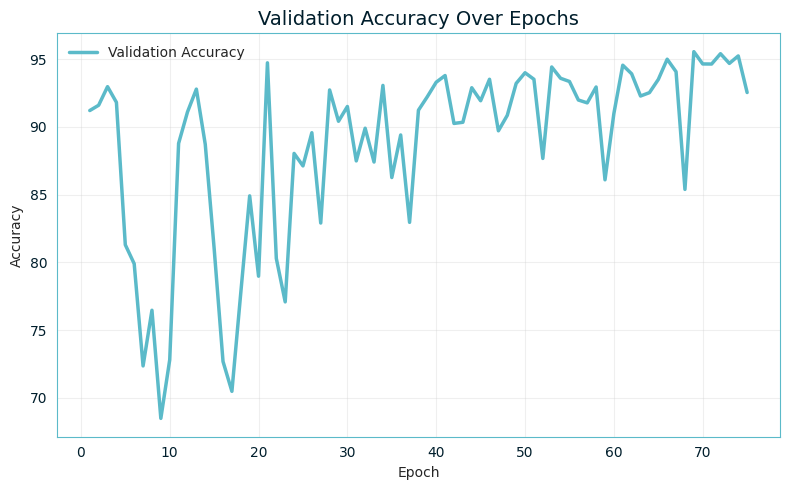

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Set seaborn style for consistency
sns.set_style("whitegrid")

# Custom ppt color palette
ppt_colors = ["#FFFFFF", "#96C7CF", "#5BBAC9", "#001E2C"]

# Update with your actual path
# log_dir = "lightning_logs/version_1117456" 
log_dir = max([os.path.join("lightning_logs", d) for d in os.listdir("lightning_logs") if d.startswith("version_")], key=os.path.getctime)

event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# Get accuracy for all lead times (overall accuracy)
accuracy_events = event_acc.Scalars('val_accuracy')
steps = list(range(1, len(accuracy_events) + 1))
values = [e.value for e in accuracy_events]

# Plot with custom color theme
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Accuracy', color=ppt_colors[2], linewidth=2.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs", fontsize=14, color=ppt_colors[3])
plt.legend(frameon=False)
plt.grid(True, alpha=0.3)

# Adjust tick/label colors to match theme
plt.gca().tick_params(colors=ppt_colors[3])
plt.gca().spines['bottom'].set_color(ppt_colors[2])
plt.gca().spines['left'].set_color(ppt_colors[2])
plt.gca().spines['right'].set_color(ppt_colors[2])
plt.gca().spines['top'].set_color(ppt_colors[2])

plt.tight_layout()
plt.savefig("val_acc_plot_UNET_ISAR_prototype_2018_2020_NORTH_test1to7Apr.png", dpi=300, bbox_inches='tight')
plt.show()


In [36]:
forecast_date = ds.time.values[0]
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

# anim = xvid(fc, 15, figsize=4, mask=land_mask)
anim = xvid(fc, 15, figsize=(4,4), mask=land_mask)
HTML(anim.to_jshtml())

INFO:root:Inspecting data
INFO:root:Initialising plot
INFO:root:Animating
INFO:root:Not saving plot, will return animation
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Check min/max of predicted SIC fraction

In [38]:
print( forecast_np[:, :, :, 0].shape )
fmin, fmax = np.min(forecast_np[:, :, :, 0]), np.max(forecast_np[:, :, :, 0])
print( f"First forecast day min: {fmin:.4f}, max: {fmax:.4f}" )

(1, 432, 432)
First forecast day min: 0.0000, max: 0.9997


#### Load original input dataset

This is the original input dataset (pre-normalisation) for comparison.

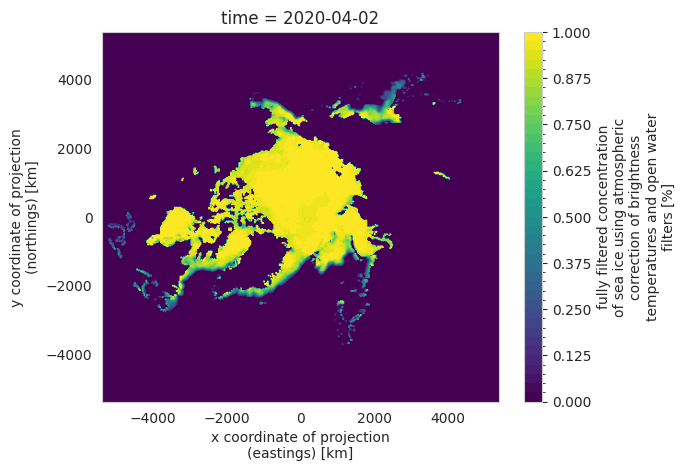

In [40]:
# Load original input dataset (domain not normalised)
xr.plot.contourf(xr.open_dataset("data/osisaf/north/siconca/2020.nc").isel(time=92).ice_conc, levels=50)

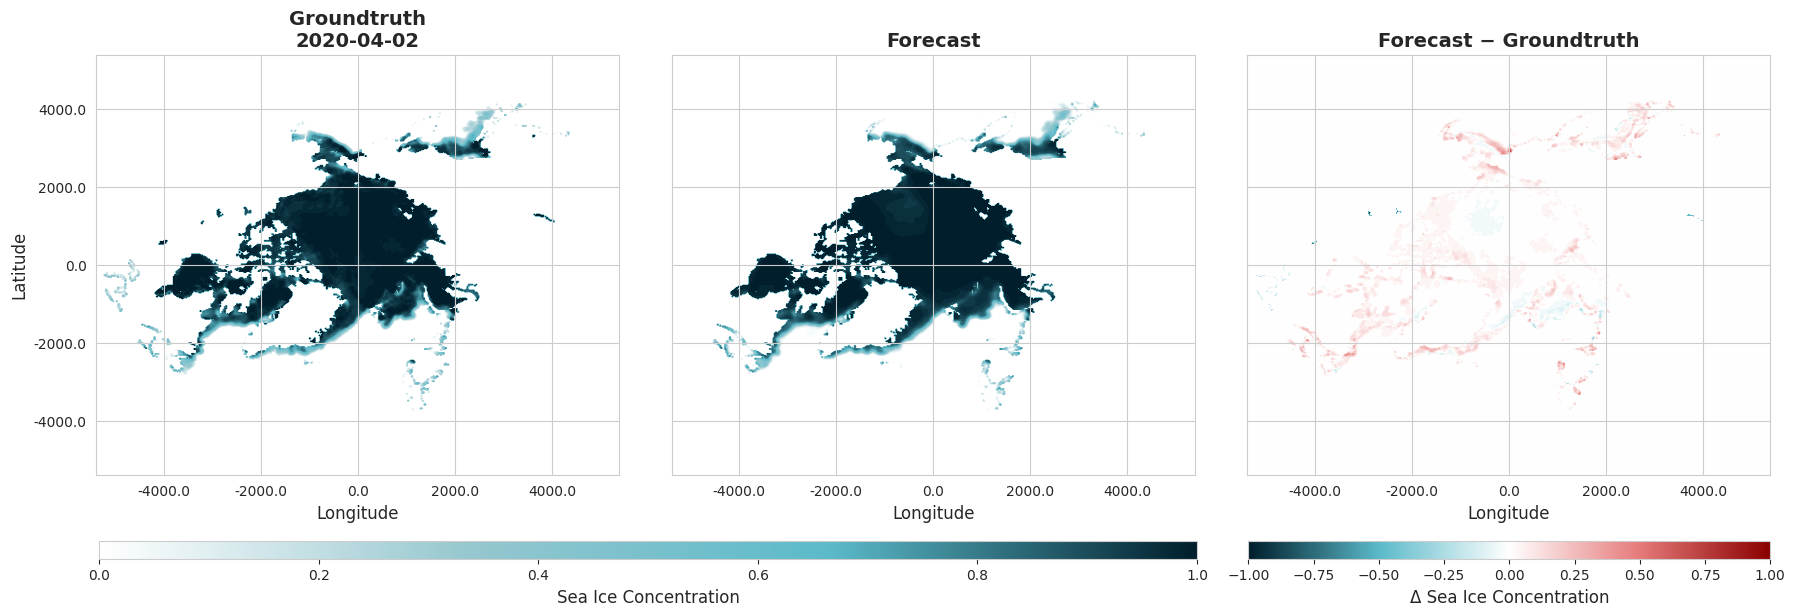

In [41]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

# --- load / select frames ---
fc_flat = fc.isel(time=0)
timestamp = pd.to_datetime(fc.time.values[0])

ds = xr.open_dataset("data/osisaf/north/siconca/2020.nc")
# ice_conc = ds.isel(time=92).ice_conc #92 is 2 april 
# ice_conc = ds.isel(time=111).ice_conc #111 is 21 april
# ice_conc = ds.isel(time=93).ice_conc #93 is 3 april
ice_conc = ds.isel(time=91).ice_conc #91 is 1 april 

# --- align grids (important) ---
ice_conc_interp = ice_conc.interp_like(fc_flat)

# --- difference ---
diff = fc_flat - ice_conc_interp

# --- colormaps ---
ppt_colors = ["#FFFFFF", "#96C7CF", "#5BBAC9", "#001E2C"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ppt_cmap", ppt_colors)

diff_colors = ["#001E2C", "#5BBAC9", "#FFFFFF", "#E67A7A", "#8B0000"]
diff_cmap = mcolors.LinearSegmentedColormap.from_list("diff_cmap", diff_colors)

# --- shared vmin/vmax for the main (gt + fc) maps ---
vmin_main = float(np.nanmin([ice_conc_interp.values.min(), fc_flat.values.min()]))
vmax_main = float(np.nanmax([ice_conc_interp.values.max(), fc_flat.values.max()]))

# --- symmetric scale for difference ---
vmax_diff = float(np.nanmax(np.abs(diff.values)))
vmin_diff = -vmax_diff

# --- figure & axes ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ground truth
im0 = ice_conc_interp.plot.contourf(
    ax=axes[0],
    levels=50,
    cmap=custom_cmap,
    vmin=vmin_main,
    vmax=vmax_main,
    add_colorbar=False,
    zorder=0,
)
axes[0].set_title(f"Groundtruth\n{timestamp.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Longitude", fontsize=12)
axes[0].set_ylabel("Latitude", fontsize=12)

# Forecast
im1 = fc_flat.plot.contourf(
    ax=axes[1],
    levels=50,
    cmap=custom_cmap,
    vmin=vmin_main,
    vmax=vmax_main,
    add_colorbar=False,
    zorder=0,
)
axes[1].set_title("Forecast", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Longitude", fontsize=12)
axes[1].set_ylabel("")

# Difference
im2 = diff.plot.contourf(
    ax=axes[2],
    levels=50,
    cmap=diff_cmap,
    vmin=vmin_diff,
    vmax=vmax_diff,
    add_colorbar=False,
    zorder=0,
)
axes[2].set_title("Forecast − Groundtruth", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Longitude", fontsize=12)
axes[2].set_ylabel("")

# --- Clean up axis tick labels ---
for i, ax in enumerate(axes):
    # Format longitude and latitude labels to be cleaner
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Reduce the number of ticks for cleaner look
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    
    # Format tick labels to remove excessive decimals
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
    # Remove y-axis labels for all except the first plot
    if i > 0:
        ax.set_yticklabels([])  # Remove y-tick labels but keep the ticks

# --- Better positioned colorbars ---
# Main colorbar - extended to match exact width of image 1 + image 2
cbar_ax1 = fig.add_axes([0.0515, 0.08, 0.61, 0.03])  # Extended width to match images 1+2
sm_main = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=vmin_main, vmax=vmax_main))
sm_main.set_array([])
cbar1 = fig.colorbar(sm_main, cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("Sea Ice Concentration", fontsize=12)
cbar1.ax.tick_params(labelsize=10)

# Diff colorbar - extended to match exact width of image 3
cbar_ax2 = fig.add_axes([0.69, 0.08, 0.29, 0.03])  # Extended width to match image 3
sm_diff = plt.cm.ScalarMappable(cmap=diff_cmap, norm=plt.Normalize(vmin=vmin_diff, vmax=vmax_diff))
sm_diff.set_array([])
cbar2 = fig.colorbar(sm_diff, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label("Δ Sea Ice Concentration", fontsize=12)
cbar2.ax.tick_params(labelsize=10)

# Adjust layout to make more room for colorbars (increased bottom margin)
plt.subplots_adjust(top=0.92, bottom=0.22, left=0.05, right=0.98, wspace=0.1)

plt.savefig(
    f"UNET_forecast_comparison_{timestamp.strftime('%Y%m%d')}_ISAR8_PROTOTYPE_2018_2020_NORTH_test1to7Apr.png",
    dpi=300,
    bbox_inches="tight",
    facecolor='white'
)
plt.show()

## Version
- IceNet Codebase: v0.2.8

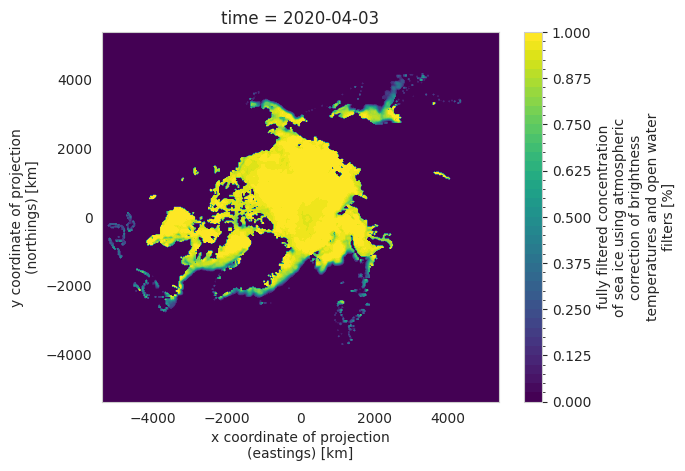

In [44]:
# Load original input dataset (domain not normalised)
xr.plot.contourf(xr.open_dataset("data/osisaf/north/siconca/2020.nc").isel(time=93).ice_conc, levels=50)

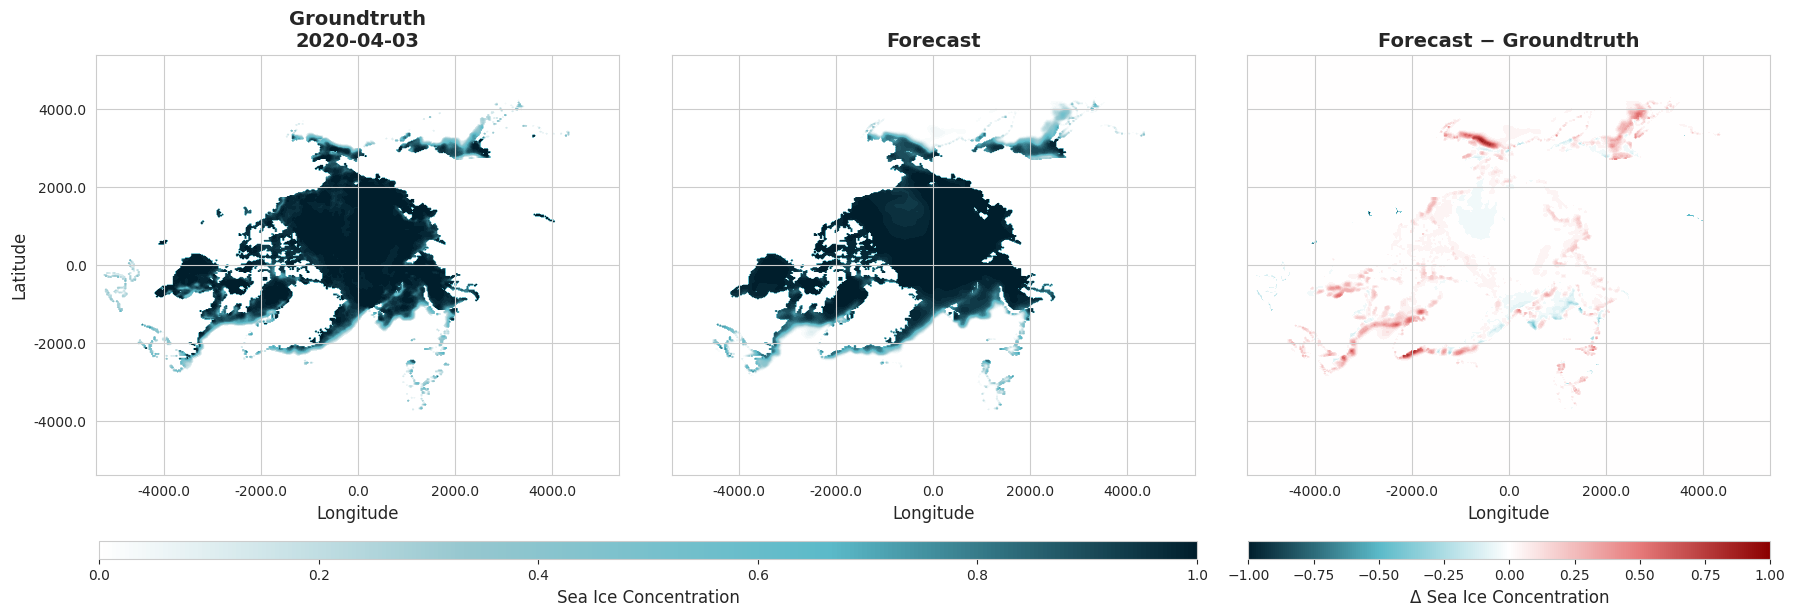

In [46]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

# --- load / select frames ---
fc_flat = fc.isel(time=1)
timestamp = pd.to_datetime(fc.time.values[1])

ds = xr.open_dataset("data/osisaf/north/siconca/2020.nc")
# ice_conc = ds.isel(time=93).ice_conc #93 is 3 april
# ice_conc = ds.isel(time=112).ice_conc #112 is 22 April
# ice_conc = ds.isel(time=94).ice_conc #94 is 4 april
ice_conc = ds.isel(time=95).ice_conc #95 is 5 april

# --- align grids (important) ---
ice_conc_interp = ice_conc.interp_like(fc_flat)

# --- difference ---
diff = fc_flat - ice_conc_interp

# --- colormaps ---
ppt_colors = ["#FFFFFF", "#96C7CF", "#5BBAC9", "#001E2C"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ppt_cmap", ppt_colors)

diff_colors = ["#001E2C", "#5BBAC9", "#FFFFFF", "#E67A7A", "#8B0000"]
diff_cmap = mcolors.LinearSegmentedColormap.from_list("diff_cmap", diff_colors)

# --- shared vmin/vmax for the main (gt + fc) maps ---
vmin_main = float(np.nanmin([ice_conc_interp.values.min(), fc_flat.values.min()]))
vmax_main = float(np.nanmax([ice_conc_interp.values.max(), fc_flat.values.max()]))

# --- symmetric scale for difference ---
vmax_diff = float(np.nanmax(np.abs(diff.values)))
vmin_diff = -vmax_diff

# --- figure & axes ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ground truth
im0 = ice_conc_interp.plot.contourf(
    ax=axes[0],
    levels=50,
    cmap=custom_cmap,
    vmin=vmin_main,
    vmax=vmax_main,
    add_colorbar=False,
    zorder=0,
)
axes[0].set_title(f"Groundtruth\n{timestamp.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Longitude", fontsize=12)
axes[0].set_ylabel("Latitude", fontsize=12)

# Forecast
im1 = fc_flat.plot.contourf(
    ax=axes[1],
    levels=50,
    cmap=custom_cmap,
    vmin=vmin_main,
    vmax=vmax_main,
    add_colorbar=False,
    zorder=0,
)
axes[1].set_title("Forecast", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Longitude", fontsize=12)
axes[1].set_ylabel("")

# Difference
im2 = diff.plot.contourf(
    ax=axes[2],
    levels=50,
    cmap=diff_cmap,
    vmin=vmin_diff,
    vmax=vmax_diff,
    add_colorbar=False,
    zorder=0,
)
axes[2].set_title("Forecast − Groundtruth", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Longitude", fontsize=12)
axes[2].set_ylabel("")

# --- Clean up axis tick labels ---
for i, ax in enumerate(axes):
    # Format longitude and latitude labels to be cleaner
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Reduce the number of ticks for cleaner look
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    
    # Format tick labels to remove excessive decimals
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
    # Remove y-axis labels for all except the first plot
    if i > 0:
        ax.set_yticklabels([])  # Remove y-tick labels but keep the ticks

# --- Better positioned colorbars ---
# Main colorbar - extended to match exact width of image 1 + image 2
cbar_ax1 = fig.add_axes([0.0515, 0.08, 0.61, 0.03])  # Extended width to match images 1+2
sm_main = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=vmin_main, vmax=vmax_main))
sm_main.set_array([])
cbar1 = fig.colorbar(sm_main, cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("Sea Ice Concentration", fontsize=12)
cbar1.ax.tick_params(labelsize=10)

# Diff colorbar - extended to match exact width of image 3
cbar_ax2 = fig.add_axes([0.69, 0.08, 0.29, 0.03])  # Extended width to match image 3
sm_diff = plt.cm.ScalarMappable(cmap=diff_cmap, norm=plt.Normalize(vmin=vmin_diff, vmax=vmax_diff))
sm_diff.set_array([])
cbar2 = fig.colorbar(sm_diff, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label("Δ Sea Ice Concentration", fontsize=12)
cbar2.ax.tick_params(labelsize=10)

# Adjust layout to make more room for colorbars (increased bottom margin)
plt.subplots_adjust(top=0.92, bottom=0.22, left=0.05, right=0.98, wspace=0.1)

plt.savefig(
    f"UNET_forecast_comparison_{timestamp.strftime('%Y%m%d')}_ISAR8_PROTOTYPE_2018_2020_NORTH_test1to7Apr.png",
    dpi=300,
    bbox_inches="tight",
    facecolor='white'
)
plt.show()